# TODO: convert model saving and loading to save_json and load_json

In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# ML
from decomposition import IterativeSparseKPCA, PCA
from kernels import build_kernel, linear_kernel, gaussian_kernel

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
import project_utils as utils
from selection import FPS
from tools import load_json, save_json

# Initial setup

In [2]:
# Load train and test sets
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [3]:
# Set structure labels for loading from the HDF5 file
n_digits = len(str(n_structures - 1))
datasets = [str(i).zfill(n_digits) for i in train_idxs]

In [4]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [5]:
n_components = 100

# Linear PCA

## DEEM 10k + IZA

In [ ]:
# TODO: change train and test sets

In [7]:
# Load train and test set indices for Deem
idxs_deem_train = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_deem_train = idxs_deem_train.size
n_deem_test = idxs_deem_test.size
n_deem = n_deem_train + n_deem_test

print(n_deem_train, n_deem_test)

7750 2250


In [8]:
# Make dummy DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

In [9]:
# Load IZA cantons
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]

In [10]:
cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [11]:
idxs_iza_train_file = '../Processed_Data/IZA_226/train.idxs' 
idxs_iza_test_file = '../Processed_Data/IZA_226/test.idxs'

# Load IZA train and test set indices
try:
    idxs_iza_train = np.loadtxt(idxs_iza_train_file, dtype=int)
    idxs_iza_test = np.loadtxt(idxs_iza_test_file, dtype=int)
    n_iza_train = len(idxs_iza_train)
    n_iza_test = len(idxs_iza_test)
    
    print(n_iza_train, n_iza_test)

# Compute indices if they don't exist
except IOError:

    # Select IZA sample
    n_iza_train = n_iza // 2
    n_iza_test = n_iza - n_iza_train
    idxs_iza = np.arange(0, n_iza)
    np.random.shuffle(idxs_iza)

    idxs_iza_train = idxs_iza[0:n_iza_train]
    idxs_iza_test = idxs_iza[n_iza_train:]
    
    np.savetxt(idxs_iza_train_file, idxs_iza_train, fmt='%d')
    np.savetxt(idxs_iza_test_file, idxs_iza_test, fmt='%d')

112 113


In [12]:
# Slices for saving KSVC and KPCovR outputs
deem_train_slice = slice(n_iza_train, None)
deem_test_slice = slice(n_iza_test, None)
iza_train_slice = slice(0, n_iza_train)
iza_test_slice = slice(0, n_iza_test)

In [13]:
deem_name = 'DEEM_10k'
all_deem_name = 'DEEM_330k'
iza_name = 'IZA_226'
deem_dir = f'../Processed_Data/{deem_name}/Data'
all_deem_dir = f'../Processed_Data/{all_deem_name}/Data'
iza_dir = f'../Processed_Data/{iza_name}/Data'

In [14]:
batch_size = 10000
n_components_pca = 4

In [15]:
for cutoff in tqdm(cutoffs):
    
    # Set PCA parameters
    pca_parameters = dict(n_components=n_components_pca) # Should be same as number of PCovR components
    
    # Set data directory
    model_dir = f'../Processed_Data/Models/{cutoff}/Linear_Models/PCA'
    output_dir = 'Linear_Models/PCA'
    
    # Prepare output files and directories
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    if not os.path.exists(f'{deem_dir}/{cutoff}/{output_dir}'):
        os.makedirs(f'{deem_dir}/{cutoff}/{output_dir}')
        
    if not os.path.exists(f'{all_deem_dir}/{cutoff}/{output_dir}'):
        os.makedirs(f'{all_deem_dir}/{cutoff}/{output_dir}')
        
    if not os.path.exists(f'{iza_dir}/{cutoff}/{output_dir}'):
        os.makedirs(f'{iza_dir}/{cutoff}/{output_dir}')
    
    pca_parameter_file = f'{model_dir}/pca_parameters.json'
    pca_model_file = f'{model_dir}/pca.json'
    center_scale_file = f'{model_dir}/center_scale.json'
    
    # Set working directory
    pca_deem_file = f'{deem_dir}/{cutoff}/{output_dir}/pca_structures.hdf5'
    pca_all_deem_file = f'{all_deem_dir}/{cutoff}/{output_dir}/pca_structures.hdf5'
    pca_iza_file = f'{iza_dir}/{cutoff}/{output_dir}/pca_structures.hdf5'

    # Load SOAPs
    deem_file = f'{deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5'
    iza_file = f'{iza_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5'

    soaps_train, soaps_test = utils.load_soaps(deem_file, iza_file,
                                               idxs_deem_train, idxs_deem_test,
                                               idxs_iza_train, idxs_iza_test,
                                               idxs_iza_delete=[RWY],
                                               train_test_concatenate=True)
    
    soaps_train, soaps_test, soaps_center, soaps_scale = \
        utils.preprocess_data(soaps_train, soaps_test, scale='global')
    
    # Save centering and scaling and PCA parameters
    save_json(dict(center=soaps_center, scale=soaps_scale), 
              center_scale_file, array_convert=True)
    save_json(pca_parameters, pca_parameter_file)
    
    # Prepare loading of the DEEM 330k structures 
    all_deem_file = f'{all_deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5'
    f = h5py.File(all_deem_file, 'r')
    deem_330k_dataset = f['0']
    
    # Prepare batches for PCA on the 330k
    n_samples_330k = deem_330k_dataset.len()
    n_batches = n_samples_330k // batch_size
    if n_samples_330k % batch_size > 0:
        n_batches += 1
        
    # Initialize PCA for structures
    pca_structures = PCA(**pca_parameters)
    
    # Fit the PCA
    pca_structures.fit(soaps_train)
    
    # Compute PCA projections
    T_train = pca_structures.transform(soaps_train)
    T_test = pca_structures.transform(soaps_test)
    
    # Save PCA projections
    utils.split_and_save(T_train, T_test,
                         idxs_deem_train, idxs_deem_test,
                         deem_train_slice, deem_test_slice,
                         output=pca_deem_file, output_format='%f',
                         hdf5_attrs=pca_parameters)

    utils.split_and_save(T_train, T_test,
                         idxs_iza_train, idxs_iza_test,
                         iza_train_slice, iza_test_slice,
                         output=pca_iza_file, output_format='%f',
                         hdf5_attrs=pca_parameters)
        
    # Save the PCA model
    save_json(pca_structures.__dict__, pca_model_file, array_convert=True)
            
    # Load PCA model (if needed)
    # pca_dict = load_json(pca_model_file, array_convert=True)
    # pca = PCA()
    # pca.__dict__ = pca_dict
        
    # Transform the data and save
    # Prepare output arrays for batch processing
    T_all_deem = np.zeros((n_samples_330k, pca_structures.V.shape[1]))

    # Read the DEEM_330k structures and compute decision functions
    # and canton predictions in batches
    for i in tqdm(range(0, n_batches), desc='Batch', leave=False):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)

        deem_330k_batch = deem_330k_dataset[batch_slice, :]
        deem_330k_batch = (deem_330k_batch - soaps_center) / soaps_scale

        T_all_deem[batch_slice] = pca_structures.transform(deem_330k_batch)

    # Save DEEM 330k LPCovR projections, decision functions, and canton predictions
    # To save the projections in the same format as `split_and_save`, 
    # use the general HDF5 saving function with list of arrays instead of 2D array
    utils.save_hdf5(pca_all_deem_file, list(T_all_deem), attrs=pca_parameters)

    # Delete SOAPs so we aren't carrying them around
    del soaps_train, soaps_test

7862.000000000491


7862.000000000022


# TESTING

In [ ]:
import matplotlib.pyplot as plt

## KPCA

In [ ]:
deem_kpca = utils.load_structures_from_hdf5('../Processed_Data/DEEM_10k/Data/3.5/Kernel_Models/Gaussian/KPCA/kpca_environments.hdf5',
                                      datasets=None, concatenate=True)
iza_kpca = utils.load_structures_from_hdf5('../Processed_Data/IZA_226onDEEM_10k/Data/3.5/Kernel_Models/Gaussian/KPCA/kpca_environments.hdf5',
                                     datasets=None, concatenate=True)
cod_kpca = utils.load_structures_from_hdf5('../Processed_Data/COD_196onDEEM_10k/Data/3.5/Kernel_Models/Gaussian/KPCA/kpca_environments.hdf5',
                                     datasets=None, concatenate=True)
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)

In [ ]:
# Indices for environments
n_Si_iza = np.loadtxt('../Processed_Data/IZA_226/n_Si.dat', dtype=int)
cantons = np.repeat(cantons, n_Si_iza)

c1_idxs = np.nonzero(cantons == 1)[0]
c2_idxs = np.nonzero(cantons == 2)[0]
c3_idxs = np.nonzero(cantons == 3)[0]
c4_idxs = np.nonzero(cantons == 4)[0]

In [ ]:
# Indices for structures
c1_idxs = np.nonzero(cantons == 1)[0]
c2_idxs = np.nonzero(cantons == 2)[0]
c3_idxs = np.nonzero(cantons == 3)[0]
c4_idxs = np.nonzero(cantons == 4)[0]

In [ ]:
plt.scatter(deem_kpca[::500, 0], deem_kpca[::500, 1], c='gray', alpha=0.1)
#plt.scatter(iza_kpca[:, 0], iza_kpca[:, 1], c='red', alpha=0.1)
plt.scatter(iza_kpca[c1_idxs, 0], iza_kpca[c1_idxs, 1], c='red', alpha=0.5)
plt.scatter(iza_kpca[c2_idxs, 0], iza_kpca[c2_idxs, 1], c='blue', alpha=0.5)
plt.scatter(iza_kpca[c3_idxs, 0], iza_kpca[c3_idxs, 1], c='green', alpha=0.5)
plt.scatter(iza_kpca[c4_idxs, 0], iza_kpca[c4_idxs, 1], c='black', alpha=0.5)
#plt.scatter(cod_kpca[:, 0], cod_kpca[:, 1], c='blue', alpha=0.1)

plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA

with open('../Processed_Data/Models/3.5/Kernel_Models/Gaussian/KRR/energies_mae_parameters.json', 'r') as f:
    kernel_params = json.load(f)
    
print(kernel_params)

In [ ]:
deem_soaps = utils.load_structures_from_hdf5('../Processed_Data/DEEM_10k/Data/3.5/soaps.hdf5',
                                       datasets=None, concatenate=True)
iza_soaps = utils.load_structures_from_hdf5('../Processed_Data/IZA_226onDEEM_10k/Data/3.5/soaps.hdf5',
                                       datasets=None, concatenate=True)
cod_soaps = utils.load_structures_from_hdf5('../Processed_Data/COD_196onDEEM_10k/Data/3.5/soaps.hdf5',
                                      datasets=None, concatenate=True)
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=10)
T = kpca.fit_transform(deem_soaps[0::500])
Ti = kpca.transform(iza_soaps[0::500])
Tc = kpca.transform(cod_soaps[0::500])

plt.scatter(T[:, 0], T[:, 1], c='gray')
plt.scatter(deem_kpca[0::500, 0], deem_kpca[0::500, 1], c='red')
#plt.scatter(Ti[:, 0], Ti[:, 1], c='red')
#plt.scatter(Tc[:, 0], Tc[:, 1], c='blue')
plt.show()

## PCA

In [22]:
deem_pca = utils.load_structures_from_hdf5('../Processed_Data/DEEM_10k/Data/6.0/Linear_Models/PCA/pca_structures.hdf5',
                                      datasets=None, concatenate=True)
iza_pca = utils.load_structures_from_hdf5('../Processed_Data/IZA_226/Data/6.0/Linear_Models/PCA/pca_structures.hdf5',
                                     datasets=None, concatenate=True)
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)

In [23]:
# Indices for structures
c1_idxs = np.nonzero(cantons_iza == 1)[0]
c2_idxs = np.nonzero(cantons_iza == 2)[0]
c3_idxs = np.nonzero(cantons_iza == 3)[0]

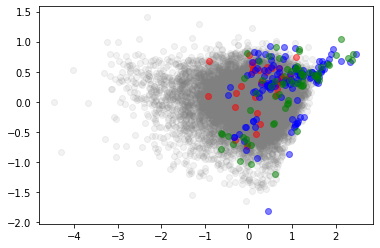

In [24]:
plt.scatter(deem_pca[:, 0], deem_pca[:, 1], c='gray', alpha=0.1)
#plt.scatter(iza_pca[:, 0], iza_pca[:, 1], c='red', alpha=0.1)
plt.scatter(iza_pca[c1_idxs, 0], iza_pca[c1_idxs, 1], c='red', alpha=0.5)
plt.scatter(iza_pca[c2_idxs, 0], iza_pca[c2_idxs, 1], c='blue', alpha=0.5)
plt.scatter(iza_pca[c3_idxs, 0], iza_pca[c3_idxs, 1], c='green', alpha=0.5)

plt.show()